In [1]:
#torch38 env
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        #left = int(crops['left'])-int(crops['width'])*0.25
        #top = int(crops['top'])-int(crops['height'])*0.25
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        if(width > height) :
            left = left - width*0.25
            top = top + height*0.5 - width*0.5 - width*0.25
            width = width*1.5
            height = width
        else :
            top = top - height*0.25
            left = left + width*0.5 - height*0.5 - height*0.25
            height = height*1.5
            width = height
            
        image = TF.crop(image, top, left, height, width)
        
        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        
        return image, landmarks

In [3]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        #tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        tree = ET.parse('./300W_LP/labels_300W_LP.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        #self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        self.root_dir= './300W_LP'
        
        for filename in root[0]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

In [4]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=0)

The length of Train set is 90714
The length of Valid set is 10079


In [5]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


In [6]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        #self.model=models.resnet18()
        self.model=models.resnet18(pretrained=True) # from vol.6
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [7]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [11]:
print(Network())

Network(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [9]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()    

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in range(1,num_epochs+1):
    epoch_time = time.time()
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'LandmarkModel_6.pth') # _0 : without edit, _1 : with squrare, _2 : 150% enlarged square 
                                                                #_3 : 150% enlarged properly(left and top points altered)
                                                                #_4 : 150% enlarged really properly...(Crop funct omitted)
                                                                #_5 : 150%...(Epoch: 10  Train Loss: 0.0011  Valid Loss: 0.0016, 7920s)
                                                                #_6 : use pretrained-model(Minimum Validation Loss of 0.0008 8190s)
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
        print("Total Elapsed Time : {} s".format(time.time()-epoch_time))
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

KeyboardInterrupt: 

Total number of test images: 10079
Elapsed Time : 0.5396287441253662


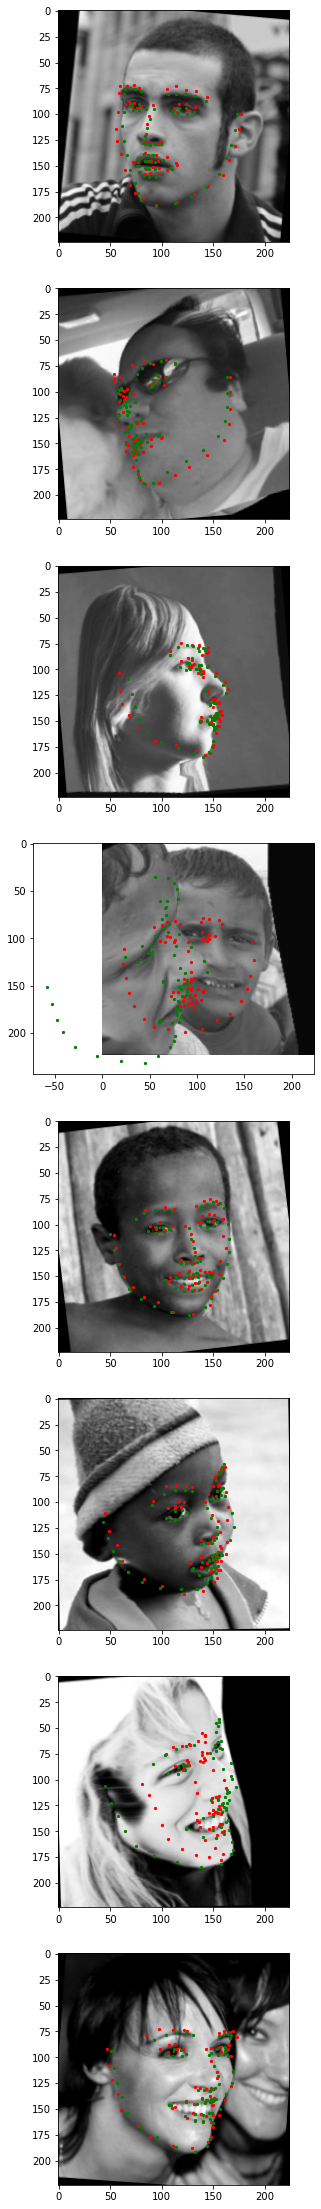

In [13]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('./LandmarkModel_6.pth'))
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,68,2)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        #print(images[img_num].cpu().numpy().shape)
        #print(images[img_num].cpu().numpy().transpose(1,2,0).shape)
        #print(images[img_num].cpu().numpy().transpose(1,2,0).squeeze().shape)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

        
print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

In [12]:
#Error
total_norm=[]
all_landmark = []

#num
for img_num in range(8) :
    for i in range(68):
        x_coord = predictions[img_num,i,0] - landmarks[img_num,i,0] #img_num = 0
        y_coord = predictions[img_num,i,1] - landmarks[img_num,i,1]
        each_norm = np.linalg.norm(np.array([x_coord, y_coord]))
        total_norm.append(each_norm)

    numerator = sum(np.array(total_norm))
    #print(numerator)

    #denom
    for ii in range(68):
        left = np.array([landmarks[img_num,33,0],landmarks[img_num,33,1]])
        right= np.array([landmarks[img_num,57,0],landmarks[img_num,57,1]])
        denom = np.linalg.norm(left - right)

    #Total
    total_error = numerator / (denom*68)
    print("total error for image",img_num,":",total_error)
    
    total_norm = []
    

total error for image 0 : 0.12655283168602577
total error for image 1 : 0.11599035962029311
total error for image 2 : 0.12037424737977083
total error for image 3 : 0.2405297327212148
total error for image 4 : 0.24140350670657437
total error for image 5 : 0.2839550351363232
total error for image 6 : 0.19347416831290856
total error for image 7 : 0.2307599801199119


TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

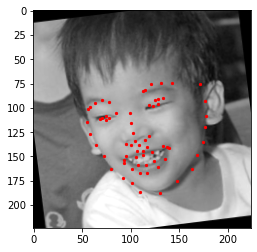

In [53]:
plt.imshow(images[3].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
plt.scatter(predictions[3,:,0], predictions[3,:,1], c = 'r', s = 5)
#plt.scatter(landmarks[3,:,0], landmarks[3,:,1], c = 'g', s = 5)
os.path.dirname(images[3].cpu().numpy().transpose(1,2,0).squeeze())

In [20]:
#Error
total_norm=[]


images, landmarks = next(iter(valid_loader))
images = images.cuda()
landmarks = (landmarks + 0.5) * 224

#num
for img_num in range(8) :
    for i in range(68):
        x_coord = predictions[img_num,i,0] - landmarks[img_num,i,0] #img_num = 0
        y_coord = predictions[img_num,i,1] - landmarks[img_num,i,1]
        each_norm = np.linalg.norm(np.array([x_coord, y_coord]))
        total_norm.append(each_norm)

    numerator = sum(np.array(total_norm))
    #print(numerator)

    #denom
    for ii in range(68):
        left = np.array([landmarks[img_num,33,0],landmarks[img_num,33,1]])
        right= np.array([landmarks[img_num,57,0],landmarks[img_num,57,1]])
        denom = np.linalg.norm(left - right)

    #Total
    total_error = numerator / (denom*68)
    print("total error for image",img_num,":",total_error)
    
    
    #reason for overhead : there's no two pupils for rotated face -> denominator should be changed to ...

total error for image 0 : 1.6289182230690664
total error for image 1 : 3.1623171116780386
total error for image 2 : 3.021417587497316
total error for image 3 : 7.6214733058947965
total error for image 4 : 9.345012276814815
total error for image 5 : 10.206261576420573
total error for image 6 : 13.365982201689935
total error for image 7 : 11.729282936911961


In [19]:
images, landmarks = next(iter(valid_loader))
images = images.cuda()
landmarks = (landmarks + 0.5) * 224
print(landmarks)
len(predictions)

tensor([[[ 68.2853,  85.3475],
         [ 66.6655,  98.7887],
         [ 64.4330, 112.1561],
         ...,
         [131.4006, 159.8960],
         [131.0088, 157.9893],
         [128.8527, 155.2501]],

        [[163.1321,  93.2270],
         [166.4309, 112.6763],
         [163.5330, 125.1330],
         ...,
         [130.5184, 159.5044],
         [133.9965, 159.5365],
         [137.4875, 158.1817]],

        [[ 65.8426, 102.3571],
         [ 63.7403, 118.1113],
         [ 65.8750, 129.9751],
         ...,
         [102.3261, 152.4347],
         [ 95.1077, 153.9973],
         [ 90.2988, 153.2421]],

        ...,

        [[ 88.2094,  94.1455],
         [ 82.8550, 112.6322],
         [ 80.4244, 129.2092],
         ...,
         [ 78.7355, 145.1352],
         [ 76.5965, 145.6996],
         [ 75.8978, 145.6562]],

        [[ 68.5321,  74.3174],
         [ 63.3231,  88.0647],
         [ 62.7445, 102.0043],
         ...,
         [ 68.7265, 144.1433],
         [ 64.2245, 140.8534],
         

8

In [22]:
tree = ET.parse('./300W_LP/labels_300W_LP.xml')
root = tree.getroot()

self.image_filenames = []
self.landmarks = []
self.crops = []
self.transform = transform
        #self.root_dir = 'ibug_300W_large_face_landmark_dataset'
self.root_dir= './300W_LP'
        
for filename in root[0]:
self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 23)